# Anderson model of localization

## parameter choices

In [1]:
myseed= 111111
width= 20
nimages= 100
img_sizeX= 100
img_sizeY= img_sizeX

validation_split= 0.1
batch_size= 64
myepochs= 20
mylr= 0.01
mywd= 1e-6

datanameformat="L{0}-{1}-s{2}"
dataname=datanameformat.format(width,nimages,img_sizeX)
#datapath = '/storage/disqs/'+'ML-Data/Anderson/Images/'+dataname # SC-RTP
datapath = '/mnt/DataDrive/'+'ML-Data/Anderson/Images/'+dataname # Ubuntu home

methodformat="Keras-OhtsukiConv2D-{0}"
method=methodformat.format(myseed)
print(dataname,"\n",datapath,"\n",method)

modelname = '/'+method+'-model-'+dataname+'.h5'
modelpath = datapath+modelname
historyname = '/'+method+'-history-'+dataname+'.pkl'
historypath = datapath+historyname

#print(datapath,modelpath,historypath)

L20-100-s100 
 /mnt/DataDrive/ML-Data/Anderson/Images/L20-100-s100 
 Keras-OhtsukiConv2D-111111


## initializations

In [2]:
#standard notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#standard libraries
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import random as rn
import os
import matplotlib.pyplot as plt
#np.random.seed(1337) # for reproducibility
#np.random.seed(2000) 

In [4]:
#machine learning libraries
import tensorflow as tf 
import keras
print("tensorflow: ",tf.__version__, ", keras: ", keras.__version__)

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
print("sklearn: ", sklearn.__version__)

tensorflow:  2.0.0 , keras:  2.3.1
sklearn:  0.22.1


Using TensorFlow backend.


In [5]:
#special subroutines
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Conv1D, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten
from keras.layers import Dropout
from keras import optimizers
from keras.models import load_model

# from tensorflow.keras.layers import Dense, Conv2D
# from tensorflow.keras.layers import Conv1D, MaxPooling2D
# from tensorflow.keras.layers import AveragePooling2D, Flatten
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential


# from tensorflow.keras.utils import to_categorical

# import numpy

## starting the main code

In [6]:
np.random.seed(myseed) # necessary for starting Numpy generated random numbers in a well-defined initial state.
rn.seed(myseed+1) # necessary for starting core Python generated random numbers in a well-defined state.

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

os.environ['PYTHONHASHSEED'] = '0'

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from tensorflow.keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.compat.v2.random.set_seed(myseed+3)
#tf.set_random_seed(1234)

#sess = tf.compat.v2.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

## reading the images

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,validation_split=validation_split)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
training_set = train_datagen.flow_from_directory(datapath,
                                                 subset='training',
                                                 target_size = (img_sizeX,img_sizeY),
                                                 batch_size = batch_size, 
                                                 class_mode='categorical',
                                                shuffle=True,seed=myseed)

validation_set= train_datagen.flow_from_directory(datapath, 
                                              subset='validation', 
                                              target_size = (img_sizeX,img_sizeY),
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                                 shuffle=False,seed=myseed)

# test_set = test_datagen.flow_from_directory('data-keras-L20-100/test_set',
#                                             target_size = (171, 171),
#                                             batch_size = batch_size,
#                                             class_mode='categorical',
#                                            shuffle=False)

Found 1530 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [9]:
# X_train, X_labels = next(training_set)
# Y_train, Y_labels = next(validation_set)
# len(X_train),len(X_labels),len(Y_train),len(Y_labels)

In [10]:
num_of_train_samples = training_set.samples
num_of_test_samples = validation_set.samples
num_classes = len(validation_set.class_indices)

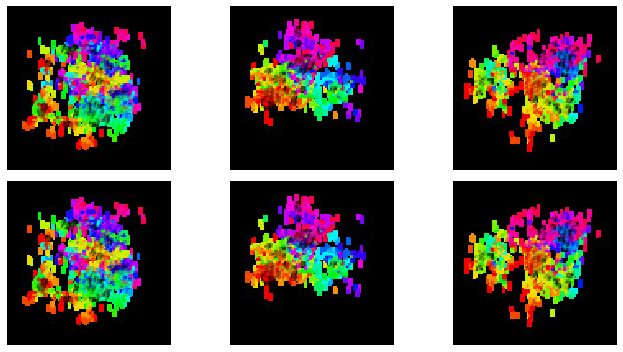

In [11]:
plt.figure(figsize=(10,5))
for i in range(6):
    plt.subplot(2,3,i+1)
    for x,y in validation_set:
        plt.imshow(x[0],cmap='hsv')
        #plt.title('y={}'.format(y[0]))
        plt.axis('off')
        break
plt.tight_layout()
plt.show()

## loading the already trained model

In [12]:
from tensorflow.keras.models import load_model
model=load_model(modelpath)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)       

## training some more

In [14]:
# training parameters
myepochs=100

# train DNN and store training info in history
history = model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples // batch_size,
                         epochs = myepochs,
                         validation_data = validation_set,
                         validation_steps = validation_set.samples // batch_size)

Epoch 1/100
23/23 [==============================] - 3s 125ms/step - loss: 2.8286 - accuracy: 0.0559 - val_loss: 2.8354 - val_accuracy: 0.0234
Epoch 2/100
23/23 [==============================] - 1s 63ms/step - loss: 2.8279 - accuracy: 0.0682 - val_loss: 2.8332 - val_accuracy: 0.0625
Epoch 3/100
23/23 [==============================] - 1s 63ms/step - loss: 2.8290 - accuracy: 0.0648 - val_loss: 2.8362 - val_accuracy: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 2s 66ms/step - loss: 2.8263 - accuracy: 0.0825 - val_loss: 2.8327 - val_accuracy: 0.0625
Epoch 5/100
23/23 [==============================] - 1s 62ms/step - loss: 2.8283 - accuracy: 0.0593 - val_loss: 2.8351 - val_accuracy: 0.0234
Epoch 6/100
23/23 [==============================] - 1s 63ms/step - loss: 2.8299 - accuracy: 0.0666 - val_loss: 2.8361 - val_accuracy: 0.0156
Epoch 7/100
23/23 [==============================] - 1s 62ms/step - loss: 2.8285 - accuracy: 0.0699 - val_loss: 2.8369 - val_accuracy: 0.0078
E

23/23 [==============================] - 1s 60ms/step - loss: 2.6552 - accuracy: 0.1317 - val_loss: 2.7216 - val_accuracy: 0.0938
Epoch 59/100
23/23 [==============================] - 1s 57ms/step - loss: 2.6822 - accuracy: 0.1199 - val_loss: 2.6999 - val_accuracy: 0.1016
Epoch 60/100
23/23 [==============================] - 1s 61ms/step - loss: 2.6635 - accuracy: 0.1207 - val_loss: 2.6781 - val_accuracy: 0.0859
Epoch 61/100
23/23 [==============================] - 1s 63ms/step - loss: 2.6942 - accuracy: 0.1223 - val_loss: 2.8729 - val_accuracy: 0.0156
Epoch 62/100
23/23 [==============================] - 1s 58ms/step - loss: 2.6517 - accuracy: 0.1357 - val_loss: 2.7634 - val_accuracy: 0.0703
Epoch 63/100
23/23 [==============================] - 1s 57ms/step - loss: 2.6580 - accuracy: 0.1370 - val_loss: 2.8255 - val_accuracy: 0.0312
Epoch 64/100
23/23 [==============================] - 1s 61ms/step - loss: 2.6286 - accuracy: 0.1269 - val_loss: 2.6848 - val_accuracy: 0.1328
Epoch 65/100

In [15]:
# tf.keras.models.save_model(history,'Anderson_Ohtsuki_model_L20_500_keras_SGD_0_01_good_input_size.h5') 
model.save(modelpath) 

import pickle 
f=open(historypath,"wb")
pickle.dump(history,f)
f.close()

TypeError: can't pickle _thread._local objects

### training history

In [ ]:
# evaluate model
score=model.evaluate(validation_set,verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
fig=plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_accuracy'+'.png')

# summarize history for loss
fig=plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.title(dataname)
plt.show()
fig.savefig(datapath+'/'+dataname+'_loss'+'.png')

### confusion matrix

In [ ]:
validation_set.reset()
label=validation_set.class_indices.keys()

#Confusion Matrix 
Y_pred = model.predict_generator(validation_set, num_of_test_samples // batch_size+1, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

#basic confusion matrix
confusion_matrix(validation_set.classes, y_pred)

In [ ]:
os.chdir('../PyCode/')
from plot_confusion_matrix import *

print(plot_confusion_matrix(confusion_matrix(validation_set.classes, y_pred),
                          label,
                          title='Confusion matrix for '+dataname,
                          cmap=None,
                          normalize=True))
os.chdir('../src/')